In [17]:
%cd /content/drive/MyDrive/Projects/diffusion_scratch

/content/drive/MyDrive/Projects/diffusion_scratch


## EDA

In [18]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [19]:
path = "Datashape.tsv"
df = pd.read_csv(path, sep='\t')

In [20]:
df.head()

,dataset,x,y
0,dino,55.3846,97.1795
1,dino,51.5385,96.0256
2,dino,46.1538,94.4872
3,dino,42.8205,91.4103
4,dino,40.7692,88.3333


In [21]:
print(f"Total rows: {len(df)}")
print(f"Columns: {df.columns.tolist()}")
print(f"Unique Datasets (Classes): {df['dataset'].unique()}")

Total rows: 1846
Columns: ['dataset', 'x', 'y']
Unique Datasets (Classes): ['dino' 'away' 'h_lines' 'v_lines' 'x_shape' 'star' 'high_lines' 'dots'
 'circle' 'bullseye' 'slant_up' 'slant_down' 'wide_lines']


In [22]:
df['dataset'].value_counts()

,count
dataset,
dino,142
away,142
h_lines,142
v_lines,142
x_shape,142
star,142
high_lines,142
dots,142
circle,142


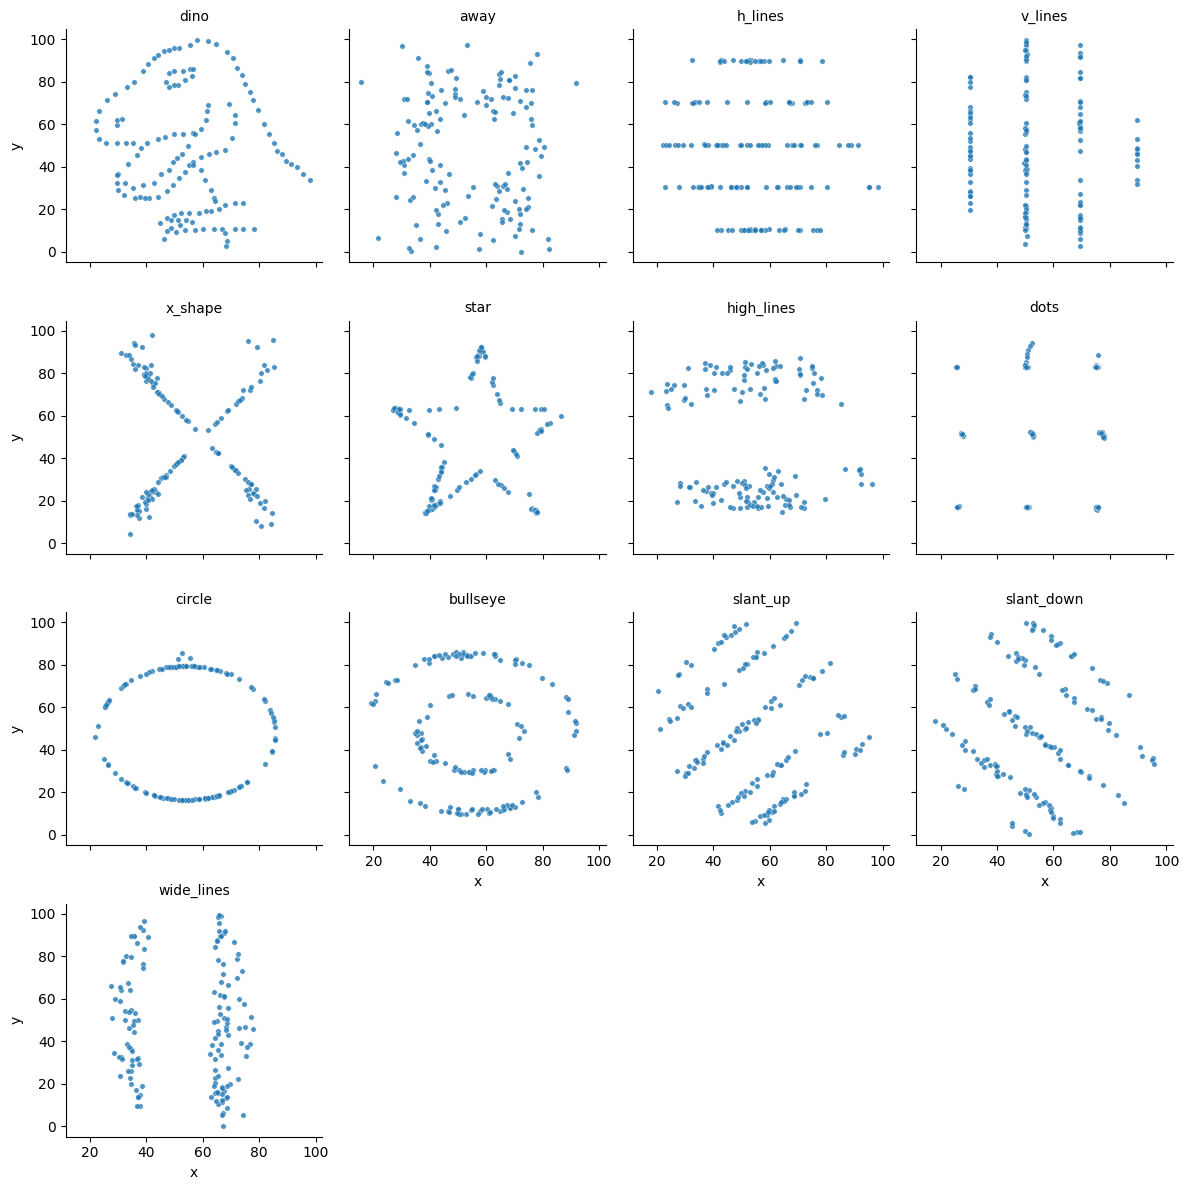

In [23]:
g = sns.FacetGrid(df, col="dataset", col_wrap=4, height=3, sharex=True, sharey=True)
g.map(sns.scatterplot, "x", "y", s=15, alpha=0.8)
g.set_titles("{col_name}")
plt.show()

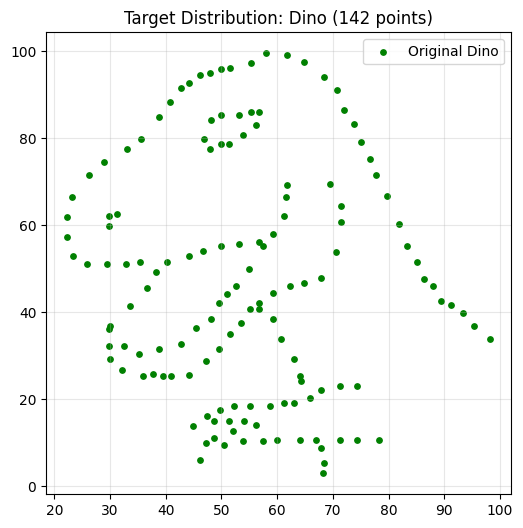

In [24]:
# Visualize only the Dino
dino_df = df[df['dataset'] == 'dino']
plt.figure(figsize=(6, 6))
plt.scatter(dino_df['x'], dino_df['y'], c='green', s=15, label='Original Dino')
plt.title(f"Target Distribution: Dino ({len(dino_df)} points)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Training

In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [26]:
# @title Model
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = np.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class SimpleDiffusionModel(nn.Module):
    def __init__(self, num_features=2, hidden_dim=512):
        super().__init__()

        # Time Embedding Block
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(hidden_dim),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU()
        )

        # Input Projection (x, y coordinates)
        self.input_mlp = nn.Linear(num_features, hidden_dim)

        self.fusion_mlp = nn.Sequential(
            nn.Linear(hidden_dim * 2, hidden_dim),
            nn.ReLU()
        )

        # Backbone (Residual Blocks)
        self.mid_mlp1 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        self.mid_mlp2 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        self.mid_mlp3 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))
        self.mid_mlp4 = nn.Sequential(nn.Linear(hidden_dim, hidden_dim), nn.ReLU(), nn.Linear(hidden_dim, hidden_dim))

        # Output Head
        self.final_layer = nn.Linear(hidden_dim, num_features)

    def forward(self, x, t):
        # x shape: [Batch, 2]
        # t shape: [Batch]

        # Embed Time
        t_emb = self.time_mlp(t) # [Batch, 512]

        # Embed Input
        x_emb = self.input_mlp(x) # [Batch, 512]

        # Result shape: [Batch, 1024]
        h_cat = torch.cat([x_emb, t_emb], dim=1)

        # Fuse back to 512
        h = self.fusion_mlp(h_cat) # [Batch, 512]

        # Residual Connections
        h = h + self.mid_mlp1(h)
        h = nn.ReLU()(h)
        h = h + self.mid_mlp2(h)
        h = nn.ReLU()(h)
        h = h + self.mid_mlp3(h)
        h = nn.ReLU()(h)
        h = h + self.mid_mlp4(h)
        h = nn.ReLU()(h)

        return self.final_layer(h)

In [27]:
# @title Scheduler
class LinearNoiseScheduler:
    def __init__(self, num_timesteps=1000, beta_start=0.0001, beta_end=0.02):
        self.num_timesteps = num_timesteps
        self.betas = torch.linspace(beta_start, beta_end, num_timesteps)
        self.alphas = 1. - self.betas
        self.alpha_cumprod = torch.cumprod(self.alphas, dim=0)
        self.sqrt_alpha_cumprod = torch.sqrt(self.alpha_cumprod)
        self.sqrt_one_minus_alpha_cumprod = torch.sqrt(1. - self.alpha_cumprod)

    def add_noise(self, x0, noise, t):
        """Forward process"""
        device = x0.device

        sqrt_alpha_bar = self.sqrt_alpha_cumprod.to(device)[t].view(-1, 1)
        sqrt_one_minus_alpha_bar = self.sqrt_one_minus_alpha_cumprod.to(device)[t].view(-1, 1)
        return (sqrt_alpha_bar * x0) + (sqrt_one_minus_alpha_bar * noise)

    def step_ddpm(self, x_t, noise_pred, t):
        """
        Standard DDPM Inverse Step
        """
        device = x_t.device

        beta_t = self.betas.to(device)[t].view(-1, 1)
        alpha_t = self.alphas.to(device)[t].view(-1, 1)
        sqrt_one_minus_alpha_cumprod_t = self.sqrt_one_minus_alpha_cumprod.to(device)[t].view(-1, 1)

        mean = (1 / torch.sqrt(alpha_t)) * (x_t - ((beta_t / sqrt_one_minus_alpha_cumprod_t) * noise_pred))

        if t[0] > 0: # If the first item is not at step 0, then the whole batch is not at step 0
            z = torch.randn_like(x_t)
            sigma_t = torch.sqrt(beta_t) # Sigma_t: This represents the standard deviation of the noise we add back.
            return mean + (sigma_t * z)
        else:
            # At the very last step (t=0), we want the clean image, so we don't add noise.
            return mean

    def step_ddim(self, x_t, noise_pred, t, t_prev):
        device = x_t.device

        t = t.view(-1)
        t_prev = t_prev.view(-1)

        alpha_bar_t = self.alpha_cumprod.to(device)[t].view(-1, 1)
        safe_prev_indices = t_prev.clamp(min=0) # Prevent negative indexing
        alpha_bar_prev = self.alpha_cumprod.to(device)[safe_prev_indices].view(-1, 1)

        # Apply mask for the t=-1 case (clean image)
        mask = (t_prev >= 0).view(-1, 1)
        alpha_bar_prev = torch.where(mask, alpha_bar_prev, torch.tensor(1.0).to(device))

        pred_x0 = (x_t - torch.sqrt(1 - alpha_bar_t) * noise_pred) / torch.sqrt(alpha_bar_t)
        dir_xt = torch.sqrt(1 - alpha_bar_prev) * noise_pred
        x_prev = (torch.sqrt(alpha_bar_prev) * pred_x0) + dir_xt
        return x_prev

In [28]:
def chamfer_distance(real_points, fake_points):
    # real_points: [N, 2]
    # fake_points: [M, 2]

    # Expand dims to create a distance matrix (NxM) using broadcasting
    # shape: [N, 1, 2] - [1, M, 2] -> [N, M, 2]
    dist_matrix = torch.norm(real_points.unsqueeze(1) - fake_points.unsqueeze(0), dim=2)

    min_dist_real_to_fake, _ = torch.min(dist_matrix, dim=1)  # For each real point, find min distance to a fake poin
    min_dist_fake_to_real, _ = torch.min(dist_matrix, dim=0)  # For each fake point, find min distance to a real point

    chamfer_dist = torch.mean(min_dist_real_to_fake) + torch.mean(min_dist_fake_to_real) # Average Chamfer Distance
    return chamfer_dist.item()

In [29]:
# Setup Data
# dino_df = df[df['dataset'] == 'dino']
data = torch.tensor(dino_df[['x', 'y']].values, dtype=torch.float32)
data_mean = data.mean(dim=0)
data_std = data.std(dim=0)
normalized_data = (data - data_mean) / data_std

dataset = TensorDataset(normalized_data)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)
print(f"Total Batches: {len(dataloader)}")

Total Batches: 2


In [30]:
# Setup Training
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SimpleDiffusionModel().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler_lr = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2000, factor=0.5)
scheduler = LinearNoiseScheduler(num_timesteps=1000, beta_start=0.00001, beta_end=0.02)

EPOCHS = 50000

In [31]:
print("Training started...")
for epoch in range(EPOCHS):
    model.train()
    for batch in dataloader:
        x0 = batch[0].to(device)

        t = torch.randint(0, 1000, (x0.shape[0],), device=device).long()  # Sample random timesteps (t) each point in the batch
        noise = torch.randn_like(x0) # Sample random noise (epsilon)
        xt = scheduler.add_noise(x0, noise, t)

        noise_pred = model(xt, t)
        loss = nn.MSELoss()(noise_pred, noise)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler_lr.step(loss.item())

    if epoch % 1000 == 0:
        print(f"Epoch {epoch} | Loss: {loss.item():.5f}")

print("Training Complete!")

Training started...
Epoch 0 | Loss: 1.44748
Epoch 1000 | Loss: 0.34192
Epoch 2000 | Loss: 0.20537
Epoch 3000 | Loss: 0.15571
Epoch 4000 | Loss: 0.23301
Epoch 5000 | Loss: 0.25912
Epoch 6000 | Loss: 0.29207
Epoch 7000 | Loss: 0.17116
Epoch 8000 | Loss: 0.18855
Epoch 9000 | Loss: 0.21611
Epoch 10000 | Loss: 0.21106
Epoch 11000 | Loss: 0.25647
Epoch 12000 | Loss: 0.34976
Epoch 13000 | Loss: 0.26952
Epoch 14000 | Loss: 0.18913
Epoch 15000 | Loss: 0.20350
Epoch 16000 | Loss: 0.28005
Epoch 17000 | Loss: 0.25124
Epoch 18000 | Loss: 0.34039
Epoch 19000 | Loss: 0.30315
Epoch 20000 | Loss: 0.25188
Epoch 21000 | Loss: 0.34808
Epoch 22000 | Loss: 0.33787
Epoch 23000 | Loss: 0.20894
Epoch 24000 | Loss: 0.24405
Epoch 25000 | Loss: 0.26353
Epoch 26000 | Loss: 0.28057
Epoch 27000 | Loss: 0.29570
Epoch 28000 | Loss: 0.30651
Epoch 29000 | Loss: 0.23914
Epoch 30000 | Loss: 0.22971
Epoch 31000 | Loss: 0.14409
Epoch 32000 | Loss: 0.30389
Epoch 33000 | Loss: 0.26162
Epoch 34000 | Loss: 0.29608
Epoch 35000 |

In [32]:
# @title DDPM and DDIM Generation Samplers
def denormalize(norm_data, mean, std):
    return (norm_data * std) + mean

# DDPM Sampler
@torch.no_grad()
def sample_ddpm(model, scheduler, n_samples=1000, device="cuda"):
    print(f"Generating {n_samples} samples using DDPM...")

    x = torch.randn(n_samples, 2).to(device)

    # Iterate backwards: T-1, T-2, ..., 0
    for i in reversed(range(scheduler.num_timesteps)):
        t = torch.full((n_samples,), i, device=device, dtype=torch.long) # t must be a Tensor [B]
        noise_pred = model(x, t)
        x = scheduler.step_ddpm(x, noise_pred, t)

    return x

# DDIM Sampler
@torch.no_grad()
def sample_ddim(model, scheduler, n_samples=1000, ddim_steps=50, device="cuda"):
    print(f"Generating {n_samples} samples using DDIM...")

    x = torch.randn(n_samples, 2).to(device)

    step_seq = torch.linspace(0, scheduler.num_timesteps - 1, ddim_steps).long().to(device) # Example: If ddim_steps=50, this gives [999, 979, ..., 20, 0]
    step_seq = list(reversed(step_seq.tolist()))

    for i in range(len(step_seq) - 1):
        curr_t = step_seq[i]
        prev_t = step_seq[i+1]

        t = torch.full((n_samples,), curr_t, device=device, dtype=torch.long)
        t_prev = torch.full((n_samples,), prev_t, device=device, dtype=torch.long)

        noise_pred = model(x, t)
        x = scheduler.step_ddim(x, noise_pred, t, t_prev)

    return x

In [33]:
# Run Sampling
model.eval()

# Generate with DDPM
print("Sampling with DDPM (1000 steps)...")
ddpm_samples = sample_ddpm(model, scheduler, n_samples=1000, device=device)
ddpm_samples_np = denormalize(ddpm_samples.cpu(), data_mean, data_std).numpy()

# Generate with DDIM
print("Sampling with DDIM (50 steps)...")
ddim_samples = sample_ddim(model, scheduler, n_samples=1000, ddim_steps=50, device=device)
ddim_samples_np = denormalize(ddim_samples.cpu(), data_mean, data_std).numpy()

Sampling with DDPM (1000 steps)...
Generating 1000 samples using DDPM...
Sampling with DDIM (50 steps)...
Generating 1000 samples using DDIM...


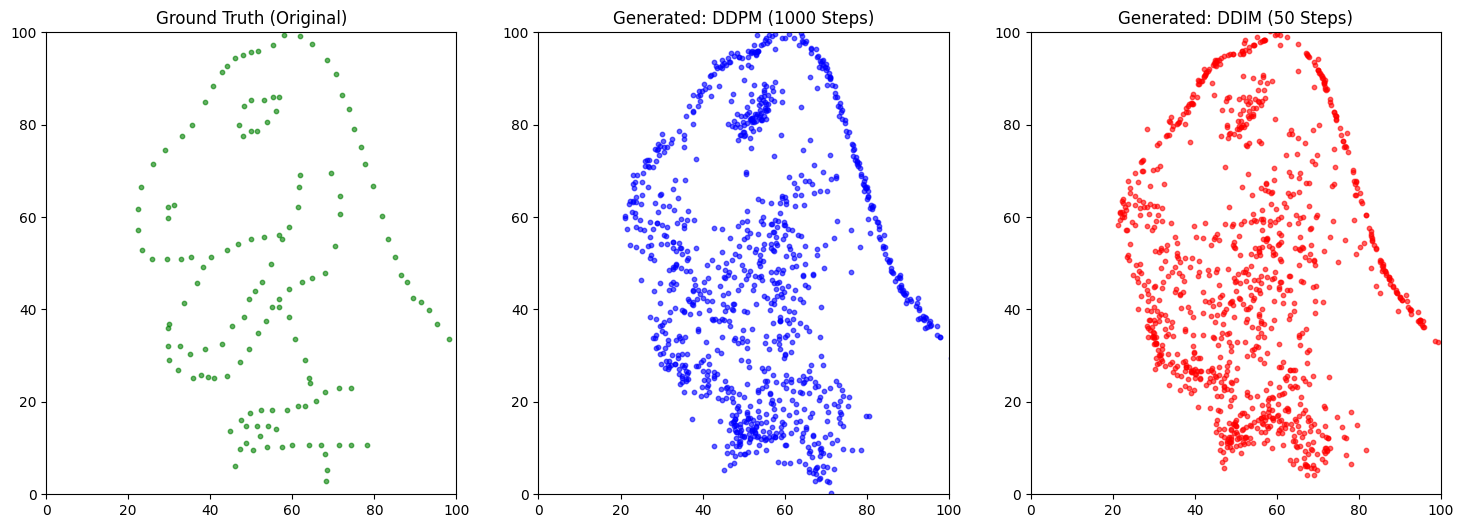

In [34]:
# Plotting
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Original Data
axes[0].scatter(dino_df['x'], dino_df['y'], s=10, c='green', alpha=0.6)
axes[0].set_title("Ground Truth (Original)")
axes[0].set_xlim(0, 100); axes[0].set_ylim(0, 100)

# DDPM
axes[1].scatter(ddpm_samples_np[:, 0], ddpm_samples_np[:, 1], s=10, c='blue', alpha=0.6)
axes[1].set_title("Generated: DDPM (1000 Steps)")
axes[1].set_xlim(0, 100); axes[1].set_ylim(0, 100)

# DDIM
axes[2].scatter(ddim_samples_np[:, 0], ddim_samples_np[:, 1], s=10, c='red', alpha=0.6)
axes[2].set_title("Generated: DDIM (50 Steps)")
axes[2].set_xlim(0, 100); axes[2].set_ylim(0, 100)

plt.show()

## Results (With the Overlay Visualization)

Chamfer Distance Score: 0.1354


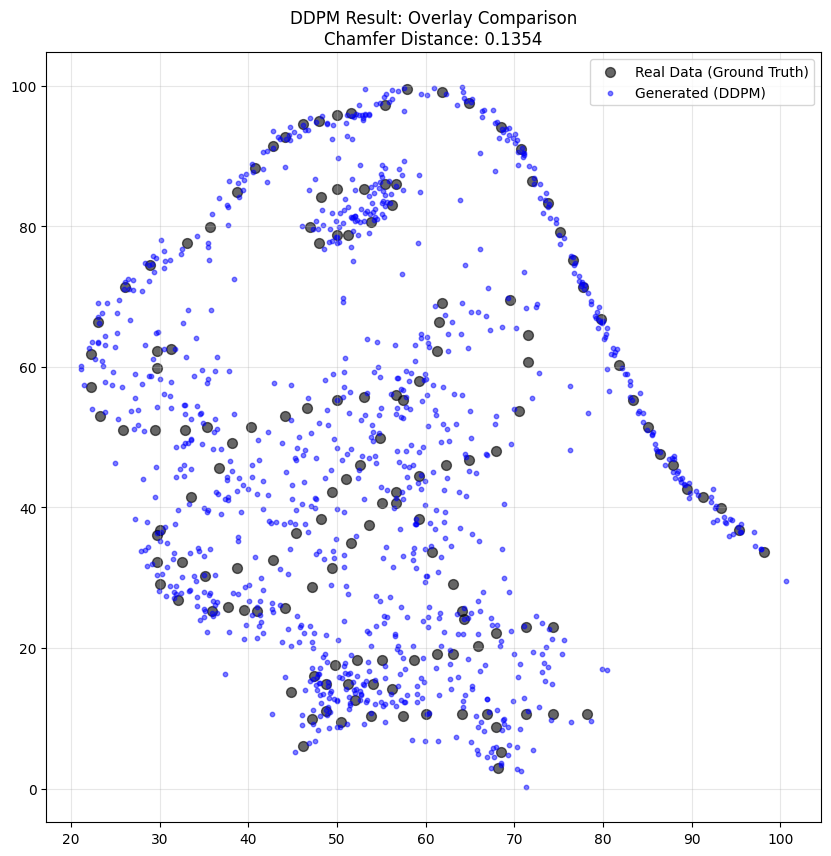

In [35]:
# @title Results for DDPM
# Calculate CD Metric
real_points_tensor = torch.tensor(dino_df[['x', 'y']].values).float().to(device)
fake_points_tensor = ddpm_samples.to(device) # Keep normalized for calculation
cd_score = chamfer_distance(
    (real_points_tensor - data_mean.to(device)) / data_std.to(device), # Normalize real to match fake
    fake_points_tensor
)
print(f"Chamfer Distance Score: {cd_score:.4f}")

# Overlay Plot
plt.figure(figsize=(10, 10))

# Plot Real Data
plt.scatter(dino_df['x'], dino_df['y'], c='black', s=50, alpha=0.6, label='Real Data (Ground Truth)')

# Plot Generated Data
plt.scatter(ddpm_samples_np[:, 0], ddpm_samples_np[:, 1], c='blue', s=10, alpha=0.5, label='Generated (DDPM)')

plt.title(f"DDPM Result: Overlay Comparison\nChamfer Distance: {cd_score:.4f}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Chamfer Distance Score: 0.1426


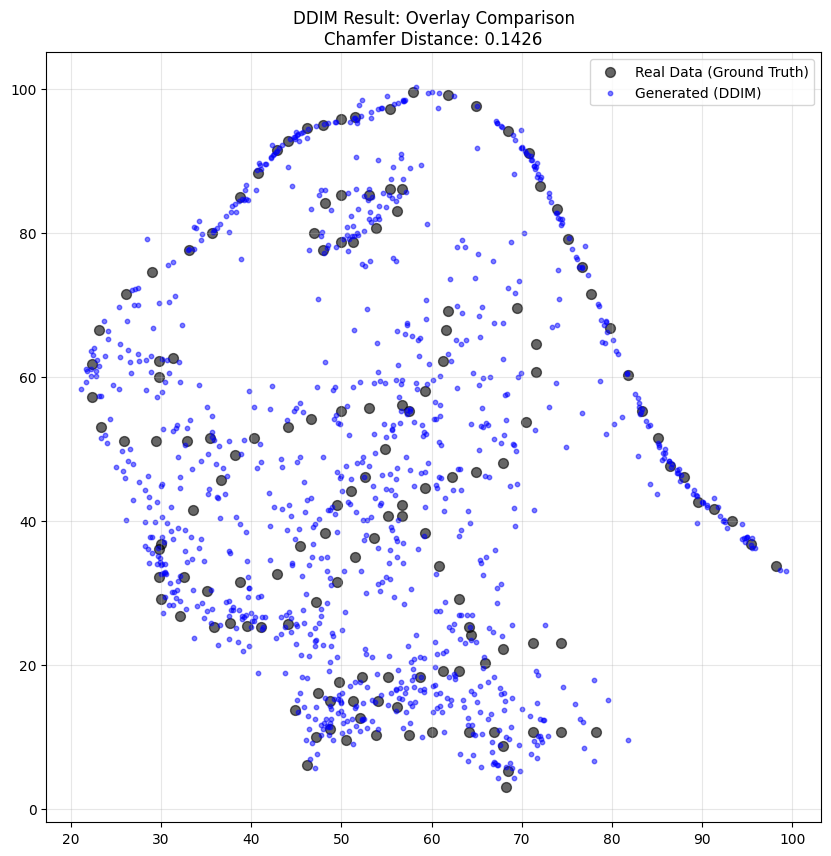

In [36]:
# @title Results for DDIM
# Calculate CD Metric
real_points_tensor = torch.tensor(dino_df[['x', 'y']].values).float().to(device)
fake_points_tensor = ddim_samples.to(device) # Keep normalized for calculation
cd_score = chamfer_distance(
    (real_points_tensor - data_mean.to(device)) / data_std.to(device), # Normalize real to match fake
    fake_points_tensor
)
print(f"Chamfer Distance Score: {cd_score:.4f}")

# Overlay Plot
plt.figure(figsize=(10, 10))

# Plot Real Data
plt.scatter(dino_df['x'], dino_df['y'], c='black', s=50, alpha=0.6, label='Real Data (Ground Truth)')

# Plot Generated Data
plt.scatter(ddim_samples_np[:, 0], ddim_samples_np[:, 1], c='blue', s=10, alpha=0.5, label='Generated (DDIM)')

plt.title(f"DDIM Result: Overlay Comparison\nChamfer Distance: {cd_score:.4f}")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()